In [79]:
import pandas as pd
import numpy as np
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

import joblib
from collections import defaultdict

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

import warnings
warnings.filterwarnings("ignore")

In [80]:
df = pd.read_parquet('data_5nullremoved/df_all_boolean12.parquet')
df_tmp = df[['default']+utils.final_features]
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)

In [81]:
logreg_brier =LogisticRegression(class_weight=None,
    C=1,penalty='l2',solver="liblinear",max_iter=3000, random_state=8)
logreg_rocauc =LogisticRegression(class_weight='balanced',
    C=1,penalty='l2',solver="liblinear",max_iter=3000, random_state=8)

catboost_brier = CatBoostClassifier(border_count=70,
        class_weights={0.0: 1.0, 1.0: 1.0},
        depth=7,
        iterations=1000,    
        l2_leaf_reg = 30,
        learning_rate = 0.01,
        loss_function='Logloss',
        verbose=0)

catboost_rocauc = CatBoostClassifier(border_count=50,
        class_weights= {0.0: 0.5072647025660025, 1.0: 34.9129711751663},
        depth=7,
        iterations=1000,    
        l2_leaf_reg = 100,
        learning_rate = 0.01,
        loss_function='Logloss',
        verbose=0)

# Fits

After experimenting with multiple models, I selected Catboost classifier and Logistic regression models. They are not balanced(class_weight=None). brier_loss was used as scoring metric for hyperparameter tuning. Roc auc got quite comparable values for both models and Roc auc for test and train samples are consistent. 

Second, the logistic regression model can measure probability directly. However, Catboost got better Brier loss score(lower).  

In [101]:
clf_list = [
    ('Logistic Regression',logreg_brier),
    ('CatBoost',catboost_brier)
]

scores = defaultdict(list)

In [102]:
X = df_tmp.drop('default', axis=1)
y = df_tmp.default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X)
#joblib.dump(scaler,"models/scaler_mm.pkl")
#scaler = joblib.load("models/scaler_mm.pkl")
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for i, (name,clf) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)
    
    for metric in [brier_score_loss,roc_auc_score, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))
    
    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    y_prob_train = clf.predict_proba(X_train)
    for metric in [roc_auc_score]:
        score_name = "Roc auc - train"
        scores[score_name].append(metric(y_train, y_prob_train[:, 1]))
        
    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Roc auc,Log loss,Precision,Recall,F1,Roc auc - train
Classifier,,,,,,,
Logistic Regression,0.013458,0.854536,0.061302,0.111111,0.002591,0.005063,0.863022
CatBoost,0.012833,0.882436,0.056849,0.583333,0.018135,0.035176,0.905516


Lets look at the calibration curve for these models. Due to stastical uncertainty in the high probability region, the result looks unstable. However, uncalibrated catboost looks better. 

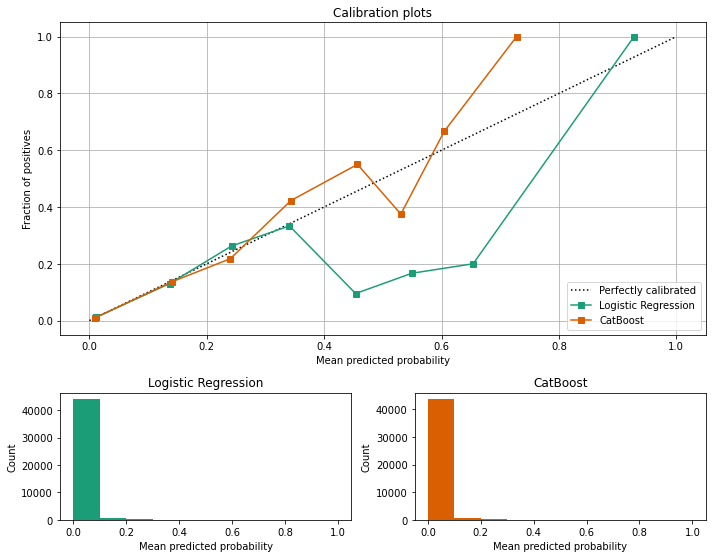

In [20]:
X = df_tmp.drop('default', axis=1)
y = df_tmp.default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X)
#joblib.dump(scaler,"models/scaler_mm.pkl")
#scaler = joblib.load("models/scaler_mm.pkl")
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (name,clf) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (name,_) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Lets look at the calibrated calibration curve. Now, Catboost looks better in the high probability region due to calibration. However, logistic regression still looks wobbly. However, logistic regression does not need to use probability calibration.

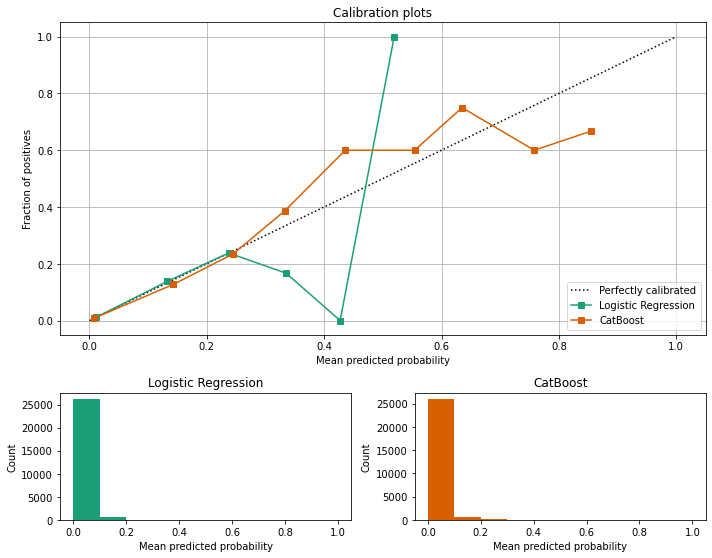

In [22]:
X = df_tmp.drop('default', axis=1)
y = df_tmp.default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X)
#joblib.dump(scaler,"models/scaler_mm.pkl")
scaler = joblib.load("models/scaler_mm.pkl")
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (name,clf) in enumerate(clf_list):
    
    if name=='Logistic Regression':
        calibrated_clf = CalibratedClassifierCV(base_estimator=clf,cv=5,method='isotonic')
        #calibrated_clf.fit(X_calib, y_calib)
        calibrated_clf.fit(X_train, y_train)
    else :
        calibrated_clf = CalibratedClassifierCV(base_estimator=clf,cv=5,method='isotonic')
        #calibrated_clf.fit(X_calib, y_calib)
        calibrated_clf.fit(X_train, y_train)

    display = CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (name,_) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()



After doing 100 random-sampled fits for both models, we still see some kind of fitting bias in Logistic regression fits. However, Catboost results look quite symmetric compared to the perfectly calibrated probability line.  

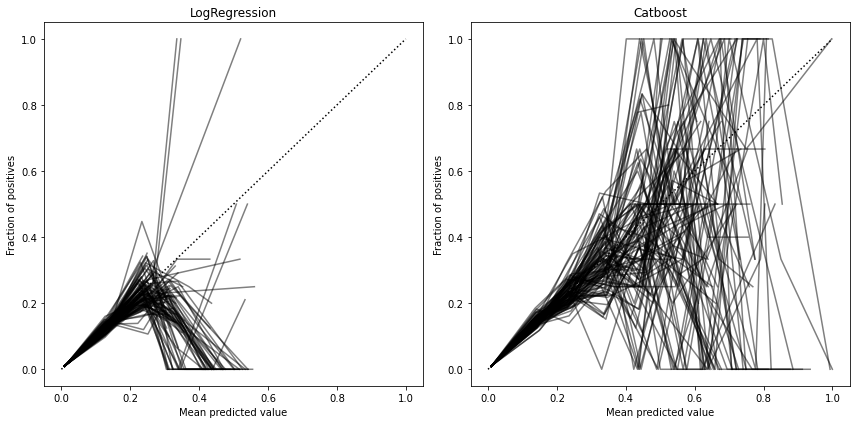

In [29]:
def plot_calibration_curve(clf, name, ax, X_test, y_test, title):

    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10, normalize=False)

    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score), alpha=0.5, color='k', marker=None)

    ax.set_ylabel("Fraction of positives")
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(title)

    ax.set_xlabel("Mean predicted value")

    plt.tight_layout()
    return clf_score

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated",)
    ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    scores = {'LogRegression':[],'Catboost':[]}


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated",)
ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

scores = {'LogRegression':[],'Catboost':[]}

for i in range(0,100):
    
    X = df_tmp.drop('default', axis=1)
    y = df_tmp.default
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=i,stratify=y)

#     scaler = MinMaxScaler()
#     scaler.fit(X)
    scaler = joblib.load("models/scaler_mm.pkl")

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    my_clf = logreg_rocauc
    
    model = CalibratedClassifierCV(my_clf,cv=3,method='isotonic',n_jobs=-1)
    model.fit(X_train, y_train)
    joblib.dump(model,"models/logreg_notbalanced_{0}.pkl".format(i))
    r = plot_calibration_curve(model, "all_cal", ax1, X_test, y_test, "LogRegression")
    scores['LogRegression'].append(r)

    my_clf = catboost_rocauc

    model = CalibratedClassifierCV(my_clf,cv=3,method='isotonic',n_jobs=-1)
    model.fit(X_train, y_train)
    joblib.dump(model,"models/catboost_notbalanced_{0}.pkl".format(i))
    r = plot_calibration_curve(model, "all_cal", ax2, X_test, y_test, "Catboost")
    scores['Catboost'].append(r)

Also, Catboot gets better brier score. 

Text(0.5, 0.98, 'Brier score')

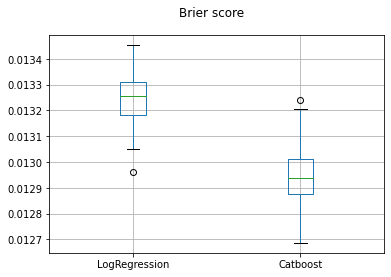

In [30]:
import pandas
b = pandas.DataFrame(scores).boxplot()
plt.suptitle('Brier score')

# Final model and Production code

Catboost classifier is used as a final model since calibrated Catboot classifier gives much more symmetric(unbiased) result. Logistic regression can give probability directly. However, it looks like that the Logistic regression results have some bias due to statistics in the high probability region. Also, I stacked the first ten catboost models from the previous plot and used as a final model to calculate the template results.   

In [110]:
catb_models = [joblib.load("models/catboost_notbalanced_{0}.pkl".format(i)) for i in range(10)]
scaler = joblib.load("models/scaler_mm.pkl")

In [111]:
final_raw_features = ['account_worst_status_0_3m', 'age', 'max_paid_inv_0_12m',
       'max_paid_inv_0_24m', 'num_arch_dc_0_12m', 'num_arch_rem_0_12m',
       'num_unpaid_bills', 'status_last_archived_0_24m',
       'sum_capital_paid_account_0_12m', 'sum_paid_inv_0_12m',
       'merchant_group','merchant_category']

df = pd.read_csv('dataset.csv',sep=";")
df_sample = pd.read_csv('template.csv',sep=";")

df_sample = df[df.uuid.isin(df_sample.uuid)].reset_index(drop=True)
df_sample = df_sample[['uuid']+final_raw_features]

In [112]:
file_for_apitest = []

In [113]:
for i in range(len(df_sample)):
    request = df_sample[final_raw_features].loc[i].to_dict()
    file_for_apitest.append(request)
    df_request = pd.DataFrame.from_dict(request,orient="index").T
    df_request = utils.data_clean_production(df_request)
    
    X = scaler.transform(df_request)
    
    y_pred_catboost = [catb_models[i].predict_proba(X)[:, 1] for i in range(10)]
    y_pred_catboost_mean= np.mean(y_pred_catboost)
    
    df_sample.loc[i,"pd"] = y_pred_catboost_mean
    

In [119]:
df_template = df_sample[['uuid','pd']]
df_template.pd = df_template.pd.round(6)
df_template.to_csv("results.csv",index=False,sep=";")

In [125]:
df_template

,uuid,pd
0,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.004317
1,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.002643
2,e9c39869-1bc5-4375-b627-a2df70b445ea,0.000032
3,6beb88a3-9641-4381-beb6-c9a208664dd0,0.009468
4,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.042487
5,e4eede99-76a3-4437-a540-3059a1eff67c,0.010298
6,a2af8d9e-9f81-4185-8fff-b2ec49d681a6,0.000181
7,ec910486-1e66-402a-80f2-08c6f04a9a1b,0.012166
8,08973cf0-646a-4fa7-9f1f-d03f76ffd59c,0.002231


In [124]:
import json
with open('template_apitest.json', 'w') as fp:
    json.dump(file_for_apitest, fp)